In [1]:
import numpy as np
import stomp_functions as stf
from scipy import linalg
import matplotlib.pyplot as plt
from qiskit.opflow import X, Z, I, MatrixEvolution
from qiskit.quantum_info import random_clifford
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

In [2]:
def create_H(N, g, j):
    """
    function for creating the ising model Hamiltonian used in the sampler calculations
    :param N:  number of sites
    :param g:  transverse field strength
    :param j:  nearest neighbor interaction
    :return:   the system hamiltonian
    """
    z_ops, x_ops = stf.construct_op_lists(N)
    
    # Construct the Hamiltonian
    # Loop over sites to construct parts of H
    H_qis = 0
    for n in range(N-1):
        H_qis += -j * z_ops[n] @ z_ops[n+1]
        for m in range(N):
            H_qis += -j * g * x_ops[m]

    return H_qis

In [3]:
def density_partition_calc(ρs, H, num_steps, λ, dτ):
    """
    function for performing the energy calculations using the density matrices
    :param ρs:         list of density matrices at each evolution step
    :param H:          system Hamiltonian
    :param num_steps:  number of evolution steps
    :param λ:          the offset parameter for sweeping over energies
    :param dτ:         the step size
    :return:           the evaluated sums with and without the observable
    """
    Z = [np.trace(ρs[1])]
    O = [np.trace(ρs[1] @ H.to_matrix())]
    for m in range(3, num_steps, 2):
        partition = 0
        expt_val = 0
        for k in range(0, m, 2):
            phase = np.exp(2j * λ * np.sqrt(0.5 * dτ) * (m - k))
            Z_k = np.trace(ρs[m-k])
            partition += np.exp(-2*(int(k/2) - m /2) ** 2 / m) * 2 * (phase * Z_k).real
            O_k = np.trace(H.to_matrix() @ ρs[m-k]) + λ * Z_k
            expt_val += np.exp(-2*(int(k/2) - m /2) ** 2 / m) * 2 * (phase * O_k).real
        
        partition = np.abs(partition)  
        Z.append(partition)
        O.append(expt_val / partition)
        
    return np.array(Z), np.array(O)

In [4]:
class TOLcmaps(object):
    """
    Class TOLcmaps definition.  Used for generating colormaps for plotting
    """
    def __init__(self):
        """
        """
        self.cmap = None
        self.cname = None
        self.namelist = (
            'rainbow_PuRd',)

        self.funcdict = dict(
            zip(self.namelist,
                (self.__rainbow_PuRd,
                )
               )
        )
        
    def __rainbow_PuRd(self):
        """
        Define colormap 'rainbow_PuRd'.
        """
        clrs = ['#6F4C9B', '#6059A9', '#5568B8', '#4E79C5', '#4D8AC6',
                '#4E96BC', '#549EB3', '#59A5A9', '#60AB9E', '#69B190',
                '#77B77D', '#8CBC68', '#A6BE54', '#BEBC48', '#D1B541',
                '#DDAA3C', '#E49C39', '#E78C35', '#E67932', '#E4632D',
                '#DF4828', '#DA2222']
        self.cmap = LinearSegmentedColormap.from_list(self.cname, clrs)
        self.cmap.set_bad('#FFFFFF')
        
    def get(self, cname='rainbow_PuRd', lut=None):
        """
        Return requested colormap, default is 'rainbow_PuRd'.
        """
        self.cname = cname
        if cname == 'rainbow_discrete':
            self.__rainbow_discrete(lut)
        else:
            self.funcdict[cname]()
        return self.cmap

In [5]:
def tol_cmap(colormap=None, lut=None):
    """
    Continuous and discrete color sets for ordered data.
    
    Return a matplotlib colormap.
    Parameter lut is ignored for all colormaps except 'rainbow_discrete'.
    """
    obj = TOLcmaps()
    if colormap is None:
        return obj.namelist
    if colormap not in obj.namelist:
        colormap = 'rainbow_PuRd'
        print('*** Warning: requested colormap not defined,',
              'known colormaps are {}.'.format(obj.namelist),
              'Using {}.'.format(colormap))
    return obj.get(colormap, lut)

In [6]:
# Set font size of plot elements
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [7]:
# Define H params
N = 8
g = 2
j = 1

In [8]:
# Define step params
τ = 0.04
num_steps = 1000
τs, dτ = np.linspace(0, τ, num_steps, retstep=True)

In [9]:
# Create H and get energies
H = create_H(N, g, j)
E = linalg.eigvalsh(H.to_matrix())

[-1.12125028e+02 -8.59975658e+01 -8.56331728e+01 -8.50822193e+01
 -8.44179657e+01 -8.37243897e+01 -8.30844854e+01 -8.25709106e+01
 -8.22394615e+01 -5.95057102e+01 -5.89547567e+01 -5.85903637e+01
 -5.82905031e+01 -5.79261101e+01 -5.75969271e+01 -5.73751566e+01
 -5.72325341e+01 -5.69570228e+01 -5.66815806e+01 -5.65926297e+01
 -5.64434479e+01 -5.61119989e+01 -5.60790549e+01 -5.60416763e+01
 -5.60173270e+01 -5.57476058e+01 -5.55281014e+01 -5.53774227e+01
 -5.51966523e+01 -5.48638478e+01 -5.46838466e+01 -5.45323987e+01
 -5.41702718e+01 -5.38388227e+01 -5.35303675e+01 -5.31989184e+01
 -5.26853436e+01 -3.24629010e+01 -3.17986474e+01 -3.12476939e+01
 -3.11050714e+01 -3.08833009e+01 -3.05541179e+01 -3.04651671e+01
 -3.01897249e+01 -2.99515923e+01 -2.99142136e+01 -2.98898643e+01
 -2.96201432e+01 -2.95498206e+01 -2.95254713e+01 -2.94006388e+01
 -2.92499600e+01 -2.90691897e+01 -2.90362458e+01 -2.89745178e+01
 -2.88855670e+01 -2.87363852e+01 -2.87047967e+01 -2.85563840e+01
 -2.84049361e+01 -2.83719

In [10]:
# Want to evolve this using rho instead of wavevectors
# Define initial ρ and U
ρ = np.eye(H.to_matrix().shape[0], dtype=complex)
ρ /= np.trace(ρ)
U = linalg.expm(1j * np.sqrt(dτ / 2) * H.to_matrix())

In [11]:
# Need to save ρ at each step for use in partition calculation
Ht = H.to_matrix()
ρs = [ρ]
ρs_tr = [np.trace(ρ)]
ρHs_tr = [np.trace(ρ @ Ht)]

for i in range(num_steps-1):
    temp = U.conj().T @ ρs[i] @ U.conj().T
    ρs.append(temp)
    ρs_tr.append(np.trace(temp))
    ρHs_tr.append(np.trace(-temp.conj().T @ Ht))

In [12]:
# Calculate using random cliffords as initial condition to mimic starting with ρ = 1
init_state = np.zeros(2 ** N)
init_state[0] = 1
old_ovlp, old_H_ovlp = np.zeros(num_steps, dtype=complex), np.zeros(num_steps, dtype=complex)
for i in range(100):
    cliff = random_clifford(N, seed=i)
    temp = stf.classical_calc(cliff.to_matrix() @ init_state,
                                              Ht, Ht, num_steps, dτ)
    old_ovlp += temp[0]
    old_H_ovlp += temp[1]
old_ovlp /= 100
old_H_ovlp /= 100

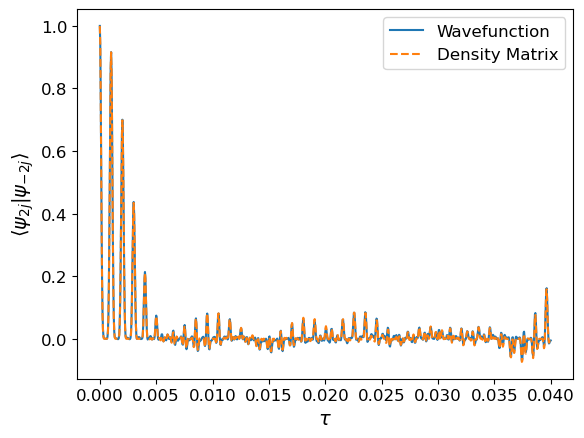

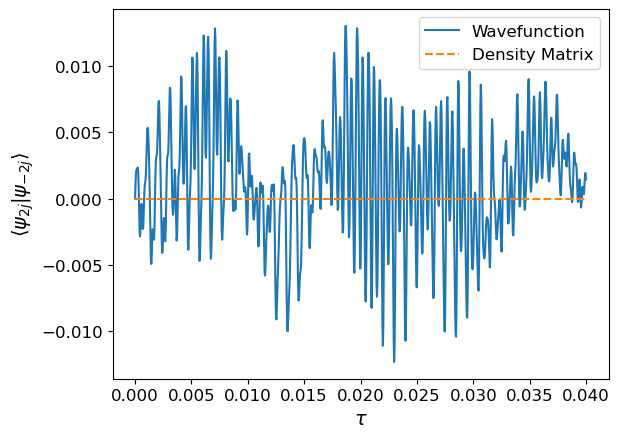

In [13]:
# Plot comparisons of the overlap lists for the density matrix and wavefunction approaches
plt.figure(1)
plt.plot(τs, old_ovlp.real, label='Wavefunction')
plt.plot(τs, np.array(ρs_tr).real, '--', label='Density Matrix')
plt.xlabel("$\\tau$")
plt.ylabel("$\\langle\\psi_{2j}|\\psi_{-2j}\\rangle$")
plt.legend()

plt.figure(2)
plt.plot(τs, old_ovlp.imag, label='Wavefunction')
plt.plot(τs, np.array(ρs_tr).imag, '--', label='Density Matrix')
plt.xlabel("$\\tau$")
plt.ylabel("$\\langle\\psi_{2j}|\\psi_{-2j}\\rangle$")
plt.legend()

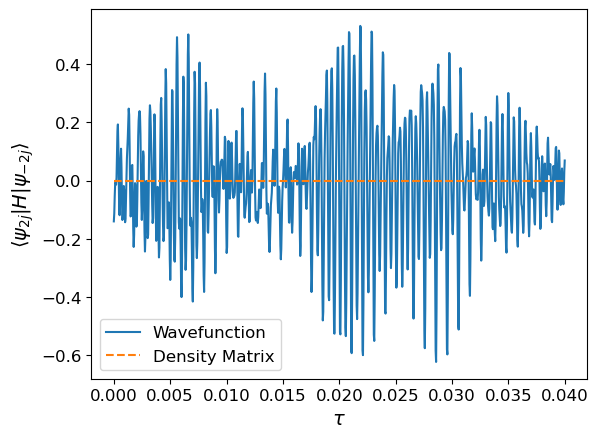

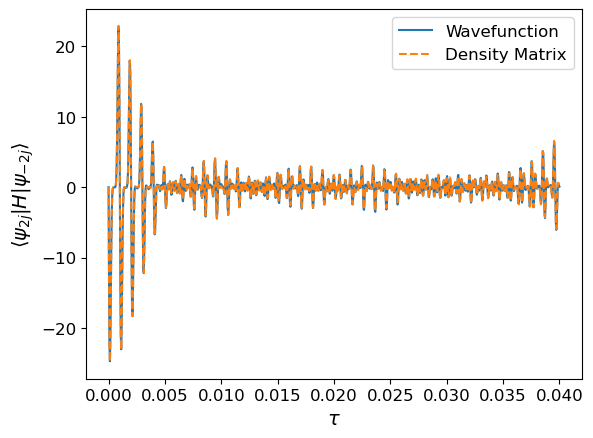

In [14]:
plt.figure(1)
plt.plot(τs, old_H_ovlp.real, label='Wavefunction')
plt.plot(τs, np.array(ρHs_tr).real, '--', label='Density Matrix')
plt.xlabel("$\\tau$")
plt.ylabel("$\\langle\\psi_{2j}|H|\\psi_{-2j}\\rangle$")
plt.legend()

plt.figure(2)
plt.plot(τs, old_H_ovlp.imag, label='Wavefunction')
plt.plot(τs, np.array(ρHs_tr).imag, '--', label='Density Matrix')
plt.xlabel("$\\tau$")
plt.ylabel("$\\langle\\psi_{2j}|H|\\psi_{-2j}\\rangle$")
plt.legend()

/home/jacob/anaconda3/envs/EnergyGaps/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


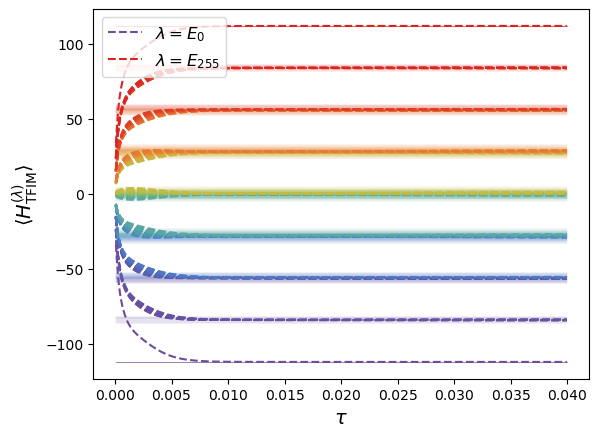

In [19]:
# Plot energy convergences
for i, λ in enumerate(E):
    if i == 0 or i == E.size-1:
        plt.plot(τs[2::2], λ * np.ones(τs[2::2].size), color=colors(i),
                 linewidth=0.5, alpha=1)
        plt.plot(τs[2::2], stf.density_partition_calc(ρs_tr, ρHs_tr, num_steps, λ, dτ)[1][1:] - λ,
            '--', color=colors(i), label='$\\lambda=E_{' +str(i) +'}$', markeredgecolor='k')
    else:
        plt.plot(τs[2::2], λ * np.ones(τs[2::2].size), color=colors(i),
                linewidth=0.25, alpha=0.5)
        plt.plot(τs[2::2], stf.density_partition_calc(ρs_tr, ρHs_tr, num_steps, λ, dτ)[1][1:] - λ,
            '--', color=colors(i), markeredgecolor='k')
plt.xlabel("$\\tau$")
plt.ylabel("$\\langle H^{(\\lambda)}_{\\mathrm{TFIM}} \\rangle$")
#plt.ylim([-15, 15])
plt.legend()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig("classical_demo1.png", format='png', dpi=300)

(array([50. , 52.5, 55. , 57.5, 60. , 62.5, 65. , 67.5, 70. ]),
 [Text(0, 50.0, '50.0'),
  Text(0, 52.5, '52.5'),
  Text(0, 55.0, '55.0'),
  Text(0, 57.5, '57.5'),
  Text(0, 60.0, '60.0'),
  Text(0, 62.5, '62.5'),
  Text(0, 65.0, '65.0'),
  Text(0, 67.5, '67.5'),
  Text(0, 70.0, '70.0')])

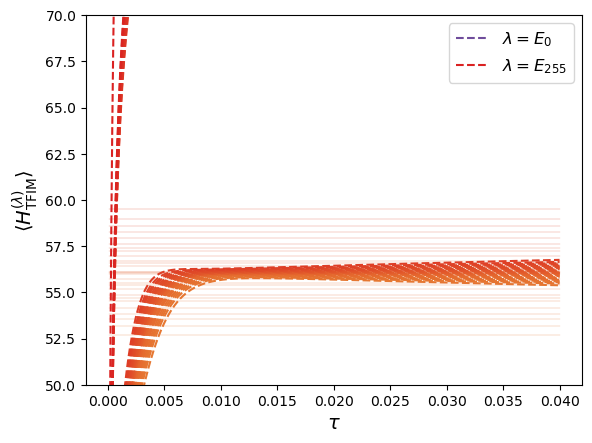

In [20]:
# Zoom in on one of the bands to see what's happening
for i, λ in enumerate(E):
    if i == 0 or i == E.size-1:
        plt.plot(τs[2::2], λ * np.ones(τs[2::2].size), color=colors(i),
                 linewidth=0.5, alpha=1)
        plt.plot(τs[2::2], stf.density_partition_calc(ρs_tr, ρHs_tr, num_steps, λ, dτ)[1][1:] - λ,
            '--', color=colors(i), label='$\\lambda=E_{' +str(i) +'}$', markeredgecolor='k')
    else:
        plt.plot(τs[2::2], λ * np.ones(τs[2::2].size), color=colors(i),
                linewidth=0.25, alpha=0.75)
        plt.plot(τs[2::2], stf.density_partition_calc(ρs_tr, ρHs_tr, num_steps, λ, dτ)[1][1:] - λ,
            '--', color=colors(i), markeredgecolor='k')
plt.xlabel("$\\tau$")
plt.ylabel("$\\langle H^{(\\lambda)}_{\\mathrm{TFIM}} \\rangle$")
plt.ylim([50, 70])
plt.legend()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

In [22]:
# Generate array of λ values to sweep over
λs = np.linspace(-1.1 * abs(E[0]), 1.1 * abs(E[0]), 1000)
calculated_energies = [stf.density_partition_calc(ρs_tr, ρHs_tr,
                                                  num_steps, _, dτ)[1][-1]
                      for _ in λs]

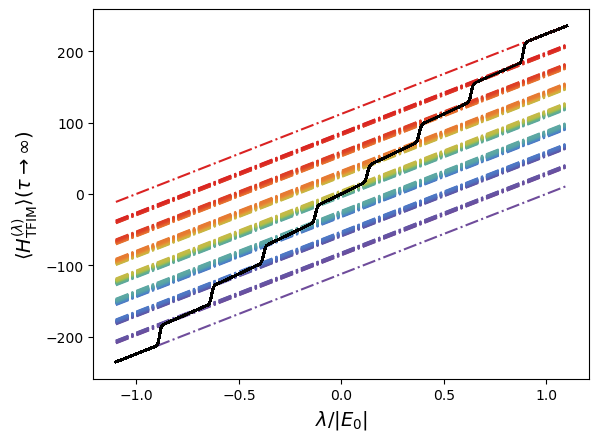

In [23]:
# Plot final calculated energy as λ varies
for i, e in enumerate(E):
    plt.plot(λs / abs(E[0]), e * np.ones(λs.shape[0]) + λs,
            '-.', color=colors(i))
    plt.plot(λs / abs(E[0]), calculated_energies, 'k')
    
plt.ylabel("$\\langle H^{(\\lambda)}_{\\mathrm{TFIM}} \\rangle(\\tau \\rightarrow \\infty)$")
plt.xlabel("$\\lambda/|E_0|$")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig("classical_demo2.png", format='png', dpi=300)

## Exact binomials vs large *m* approximation

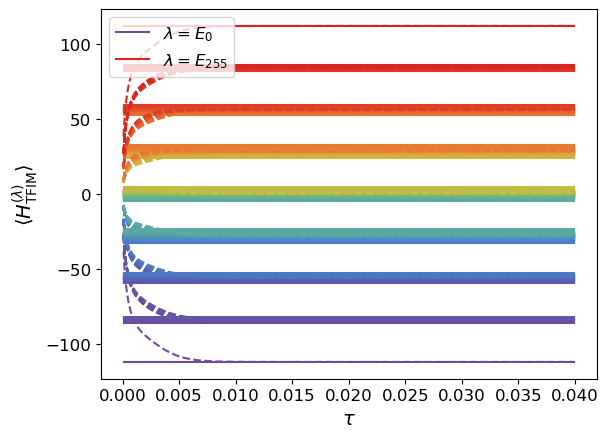

In [27]:
# Perform calculations using exact binomials to compare to previous results obtained using 
# the large m approximation
for i, λ in enumerate(E):
    if i == 0 or i == E.size-1:
        plt.plot(τs[2::2], λ * np.ones(τs[2::2].size), color=colors(i),
                 label='$\\lambda=E_{' +str(i) +'}$')
    else:
        plt.plot(τs[2::2], λ * np.ones(τs[2::2].size), color=colors(i))
        
    plt.plot(τs[2::2], stf.exact_density_partition_calc(ρs_tr, ρHs_tr, num_steps, λ, dτ)[1][1:] - λ,
            '--', color=colors(i+1))
plt.xlabel("$\\tau$")
plt.ylabel("$\\langle H^{(\\lambda)}_{\\mathrm{TFIM}} \\rangle$")
#plt.ylim([-15, 15])
plt.legend()
plt.savefig("exact_classical_demo1.png", format='png', dpi=300)

In [29]:
# Calculate the relative error between the large m approx and the exact binomial calculations
#   Note: because the values in the middle are ~0, we need to use a different reference value
#         to get accurate relative error values.  We choose the ground state here
rel_err = {}
for λ in E:
    exact_part = stf.exact_density_partition_calc(ρs_tr, ρHs_tr, num_steps, λ, dτ)[1][-1] - λ
    approx_part = stf.density_partition_calc(ρs_tr, ρHs_tr, num_steps, λ, dτ)[1][-1] - λ
    rel_err[λ] = np.abs(exact_part - approx_part) / np.abs(min(E))

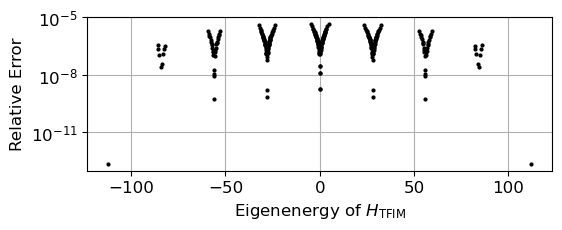

In [31]:
# Plot relative error vs the eigenvalues
plt.figure(figsize=(6, 2))
plt.semilogy(E, rel_err.values(), 'k.', alpha=1, ms=4)
plt.xlabel("Eigenenergy of $H_{\\mathrm{TFIM}}$", fontsize=12)
plt.ylabel("Relative Error", fontsize=12)
plt.grid(axis='both')
plt.savefig("rel_err_large_m.png", dpi=300, format='png', bbox_inches='tight')